# Inputs

In [1]:
import os
import pandas as pd
import yaml

In [2]:
DATASET_PARAMS = yaml.load(open("configs/dataset.yaml"), Loader=yaml.SafeLoader)
PREPROCESSING_PARAMS = yaml.load(open("configs/preprocessing.yaml"), Loader=yaml.SafeLoader)
MODEL_NAME = yaml.load(open("configs/model.yaml"), Loader=yaml.SafeLoader)['MODEL_NAME']
MODEL_PARAMS = yaml.load(open("configs/model.yaml"), Loader=yaml.SafeLoader)[MODEL_NAME]
TRAINING_PARAMS = yaml.load(open("configs/training.yaml"), Loader=yaml.SafeLoader)

In [3]:
categories =  DATASET_PARAMS['CATEGORIES']

BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, DATASET_PARAMS['DATA_PATH'])

TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "val")
TEST_DIR = os.path.join(DATASET_DIR, "test")

In [4]:
from src.utils import get_device, set_seed

set_seed(DATASET_PARAMS['SEED'])
DEVICE = get_device()
print(f"Using device: {DEVICE}")

Using device: cuda


# Dataset

In [5]:
from src.utils import split_dataset

In [6]:
train_filenames_df, val_filenames_df, test_filenames_df = split_dataset(DATASET_DIR, 
                                                                        categories, 
                                                                        DATASET_PARAMS['UC_SOURCE'], 
                                                                        shuffle=DATASET_PARAMS['IS_SHUFFLE'], 
                                                                        seed=DATASET_PARAMS['SEED'], 
                                                                        split_ratio=DATASET_PARAMS['SPLIT_RATIO'])

## Inspect dataset


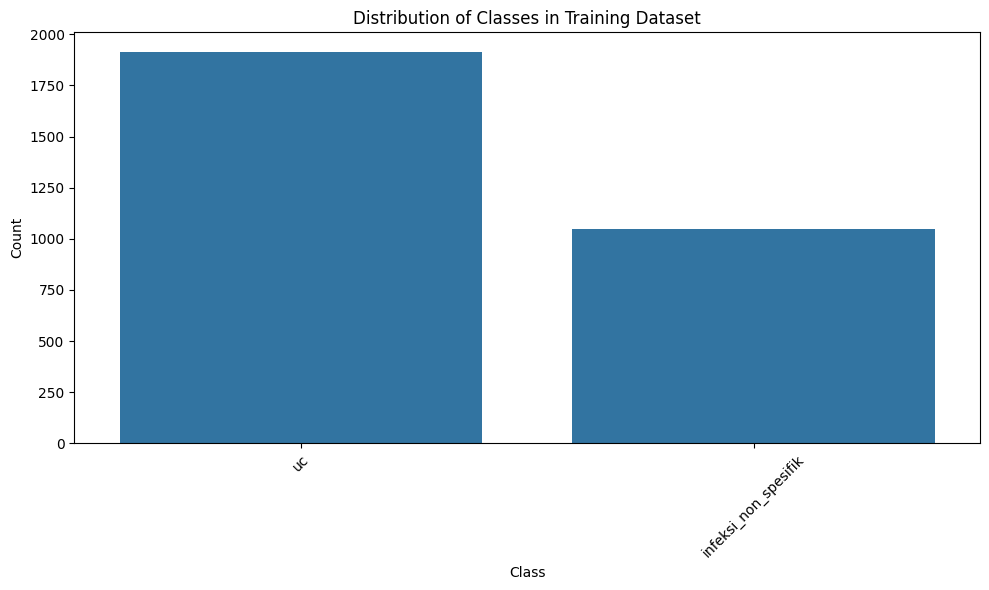

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=train_filenames_df, x='class')
plt.title('Distribution of Classes in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Pre Processor

In [8]:
from src.preprocessing import preprocess

target_input_size = tuple(PREPROCESSING_PARAMS['INPUT_SIZE'])
train_transform = preprocess(
    target_input_size=target_input_size,
    rotation_range=PREPROCESSING_PARAMS['ROTATION_RANGE'],
    width_shift_range=PREPROCESSING_PARAMS['WIDTH_SHIFT_RANGE'],
    height_shift_range=PREPROCESSING_PARAMS['HEIGHT_SHIFT_RANGE'],
    brightness_range=PREPROCESSING_PARAMS['BRIGHTNESS_RANGE'],
    zoom_range=PREPROCESSING_PARAMS['ZOOM_RANGE'],
    horizontal_flip=PREPROCESSING_PARAMS['HORIZONTAL_FLIP'],
    vertical_flip=PREPROCESSING_PARAMS['VERTICAL_FLIP'],
    channel_shift_range=PREPROCESSING_PARAMS['CHANNEL_SHIFT_RANGE'],
    fill_mode=PREPROCESSING_PARAMS['FILL_MODE'],
    shear_range=PREPROCESSING_PARAMS['SHEAR_RANGE']
    )

val_transform = preprocess(target_input_size=target_input_size) # only rescaling

In [9]:
from src.dataset import Dataset

train_dataset = Dataset(dataframe=train_filenames_df, 
                        categories=DATASET_PARAMS['CATEGORIES'],
                        transform=train_transform, 
                        seed=42, 
                        shuffle=TRAINING_PARAMS['SHUFFLE'])

val_dataset = Dataset(dataframe=val_filenames_df, 
                      categories=DATASET_PARAMS['CATEGORIES'],
                      transform=val_transform, 
                      seed=42, 
                      shuffle=TRAINING_PARAMS['SHUFFLE'])


## Train loader

In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, 
                          batch_size=TRAINING_PARAMS['BATCH_SIZE'], 
                          shuffle=False, 
                          num_workers=TRAINING_PARAMS['NUM_WORKERS'])

val_loader = DataLoader(val_dataset, 
                          batch_size=TRAINING_PARAMS['BATCH_SIZE'], 
                          shuffle=False, 
                          num_workers=TRAINING_PARAMS['NUM_WORKERS'])

# Model

In [11]:
num_classes = len(categories)

### EfficientCapsNet

In [12]:
if MODEL_NAME == "CAPSNET":
    from src.model import EfficientCapsNet
    from src.loss import MarginLoss, marginLoss

    model = EfficientCapsNet(input_size=(MODEL_PARAMS['INPUT_SIZE']))
    loss = MarginLoss()
    # loss = marginLoss

### DenseNet

In [13]:
if MODEL_NAME == "DENSENET121":
    from src.densenet import DenseNet121
    from torch.nn import CrossEntropyLoss

    model = DenseNet121(num_classes=num_classes, dropout_rate=MODEL_PARAMS['DROPOUT_RATE'])
    loss = CrossEntropyLoss()   

# Training

## Metrics

In [14]:
# Optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=TRAINING_PARAMS['LEARNING_RATE'])

# use torcheval metrics
# metrics
from torcheval.metrics import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassPrecision,
    MulticlassAUROC,
    MulticlassAUPRC,
    MulticlassRecall
)

# Metrics
from src.metrics import (
    MulticlassMCC,
    MulticlassSpecificity
)

metrics = {
    "mcc": MulticlassMCC(num_classes=num_classes, device=DEVICE),
    # "auprc": MulticlassAUPRC(num_classes=num_classes, average= TRAINING_PARAMS['AVERAGE'], device=DEVICE),
    # "auroc": MulticlassAUROC(num_classes=num_classes, average= TRAINING_PARAMS['AVERAGE'], device=DEVICE),
    "accuracy": MulticlassAccuracy(num_classes=num_classes, average= TRAINING_PARAMS['AVERAGE'], device=DEVICE),
    # "f1_score": MulticlassF1Score(num_classes=num_classes, average= TRAINING_PARAMS['AVERAGE'], device=DEVICE),
    # "precision": MulticlassPrecision(num_classes=num_classes, average=TRAINING_PARAMS['AVERAGE'], device = DEVICE),
    # "recall": MulticlassRecall(num_classes=num_classes, average=TRAINING_PARAMS['AVERAGE'], device = DEVICE),
    # "specificity": MulticlassSpecificity(num_classes=num_classes, average=TRAINING_PARAMS['AVERAGE'], device = DEVICE)
}

In [15]:
train_filenames_df.head()

,image_path,class
0,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,uc
1,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,infeksi_non_spesifik
2,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,uc
3,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,infeksi_non_spesifik
4,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,infeksi_non_spesifik


In [ ]:
from src.train import train

history = train(model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=loss, 
    optimizer=optimizer, 
    num_epochs=TRAINING_PARAMS['NUM_EPOCHS'], 
    device=DEVICE,
    metrics=metrics,
    print_every=TRAINING_PARAMS['PRINT_EVERY'],
    save_patience=TRAINING_PARAMS['SAVE_PATIENCE'],
    save_path=TRAINING_PARAMS['SAVE_PATH'],
    save_model=TRAINING_PARAMS['SAVE_MODEL'],
    save_metrics=TRAINING_PARAMS['SAVE_METRICS']
    )

Training...

Epoch 1/25


c:\Users\Yuno\anaconda3\envs\xdl-env\lib\site-packages\torcheval\metrics\functional\classification\accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorAdvancedIndexing.cpp:234.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


Epoch 1 Train - Loss: 0.3062, Metrics: {mcc: 0.7587, accuracy: 0.8801}
Epoch 1 Val - Loss: 0.6449, Metrics: {mcc: 0.7630, accuracy: 0.8944}
Model saved to artifacts/effcapsnet\epoch_1.pth

Epoch 2/25
Epoch 2 Train - Loss: 0.1646, Metrics: {mcc: 0.9008, accuracy: 0.9518}
Epoch 2 Val - Loss: 0.2020, Metrics: {mcc: 0.8644, accuracy: 0.9440}
Model saved to artifacts/effcapsnet\epoch_2.pth

Epoch 3/25


In [20]:
history.keys()

dict_keys(['train_loss', 'val_loss', 'train_metrics', 'val_metrics'])

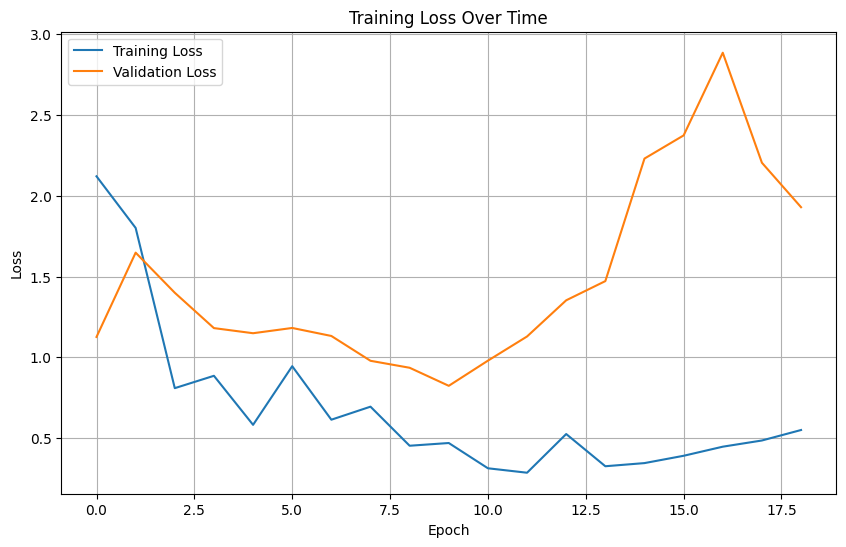

In [22]:
import matplotlib.pyplot as plt

train_loss = history["train_loss"]
val_loss = history["val_loss"]
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
